# CIFAR-10 image classification example

## Preparation

Install packages first.

In [1]:
!pip install -U torch torchvision bentoml pillow

Requirement already up-to-date: torch in /Users/leon.sun/anaconda3/lib/python3.7/site-packages (1.1.0.post2)
Requirement already up-to-date: torchvision in /Users/leon.sun/anaconda3/lib/python3.7/site-packages (0.3.0)
Requirement already up-to-date: bentoml in /Users/leon.sun/anaconda3/lib/python3.7/site-packages (0.3.0)
Requirement already up-to-date: pillow in /Users/leon.sun/anaconda3/lib/python3.7/site-packages (6.1.0)


Import packages

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

## Loading and normalizing CIFAR10

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Let try a random 32x32 input. Note: expected input size of this net (LeNet) is 32x32. To use this net on MNIST dataset, please resize the images from the dataset to 32x32.

In [4]:
input = Variable(torch.randn(1, 1, 32, 32))
print(input)
out = net(input)

tensor([[[[-0.3186, -0.1893,  1.2078,  ..., -1.4608, -0.4801,  1.4870],
          [-0.1356, -1.5239,  1.4651,  ..., -0.7415, -0.7805, -0.9428],
          [ 0.5113, -1.7719,  0.1122,  ..., -0.6782, -0.1496, -0.0952],
          ...,
          [-0.2692,  2.7017, -0.1788,  ..., -0.3562, -0.3985, -0.0764],
          [ 0.8482, -1.6187, -1.2800,  ..., -0.4948,  0.2618, -1.4255],
          [-0.2934,  0.4214,  0.0453,  ..., -0.6880, -1.2599,  0.4680]]]])


The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

Zero the gradient buffers of all parameters and backprops with random gradients:

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

  cat   cat horse   cat


## Define a Convolutional Neural Network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network


This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.194
[1,  4000] loss: 1.838
[1,  6000] loss: 1.637
[1,  8000] loss: 1.564
[1, 10000] loss: 1.517
[1, 12000] loss: 1.460
[2,  2000] loss: 1.412
[2,  4000] loss: 1.367
[2,  6000] loss: 1.340
[2,  8000] loss: 1.321
[2, 10000] loss: 1.278
[2, 12000] loss: 1.284
Finished Training


## Test the network on the test data

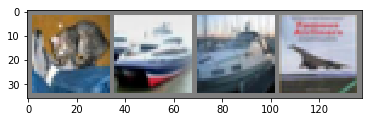

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [12]:
input = Variable(torch.randn(3, 32, 32))
out = net(input.unsqueeze(0))
print(out)

tensor([[-1.0544,  4.3963, -1.2119,  0.8730, -1.8338, -0.8393,  2.9597, -3.1199,
         -0.7750,  2.9410]], grad_fn=<AddmmBackward>)


## Define ML service with BentoML


In [13]:
%%writefile pytorch_model.py

import bentoml
from bentoml.artifact import PytorchModelArtifact
from bentoml.handlers import ImageHandler
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

@bentoml.env(conda_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('net')])
class Cifar10Model(bentoml.BentoService):
    @bentoml.api(ImageHandler)
    def predict(self, img):
        img = Image.fromarray(img).resize((32, 32))
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        input_data = transform(img)

        outputs = self.artifacts.net(Variable(input_data).unsqueeze(0))
        _, output_classes = outputs.max(dim=1)

        return classes[output_classes]

Overwriting pytorch_model.py


## Save the model

In [14]:
from pytorch_model import Cifar10Model
new_model = Cifar10Model.pack(net=net)


saved_path = new_model.save('/tmp/bento')
print(saved_path)

[2019-07-24 22:57:55,282] INFO - Searching for dependant modules of pytorch_model:/Users/leon.sun/gallery/pytorch/cifar10_image_classification/pytorch_model.py
[2019-07-24 22:58:09,770] INFO - Copying local python module '/Users/leon.sun/gallery/pytorch/cifar10_image_classification/pytorch_model.py'
[2019-07-24 22:58:09,772] INFO - Done copying local python dependant modules
[2019-07-24 22:58:09,871] INFO - BentoService Cifar10Model:2019_07_24_7fb427ea saved to /tmp/bento/Cifar10Model/2019_07_24_7fb427ea
/tmp/bento/Cifar10Model/2019_07_24_7fb427ea


## Use BentoML Archive as CLI TOOL

In [15]:
!pip install {saved_path}

Processing /tmp/bento/Cifar10Model/2019_07_24_7fb427ea
  Stored in directory: /private/var/folders/nd/78qspqxx5hz86j295sxyn7qr0000gn/T/pip-ephem-wheel-cache-5qcoa3bh/wheels/53/0a/8c/080256e260ee486416bb956df96802c105e7a415a3de5a17ce
Successfully built Cifar10Model
  Found existing installation: Cifar10Model 2019-07-24-bfb5f47a
    Uninstalling Cifar10Model-2019-07-24-bfb5f47a:
      Successfully uninstalled Cifar10Model-2019-07-24-bfb5f47a


In [16]:
!Cifar10Model predict --input=bird.jpg

bird


## Run REST API Server

In [17]:
!bentoml serve {saved_path}

 * Serving Flask app "Cifar10Model" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 193-026-865
127.0.0.1 - - [24/Jul/2019 23:05:40] "POST /predict HTTP/1.1" 200 -
^C


Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```
curl -X POST "http://127.0.0.1:5000/predict" -H "accept: */*" -H "Content-Type: image/*" --data-binary "@bird.jpg"
```